In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import yfinance as yf
import pandas as pd

%matplotlib inline

In [2]:
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2025-03-13', end='2025-03-21', interval='1m')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
for i in range(21, 28, 8):
    data = pd.concat([data, yf.download(ticker, start=f'2025-03-{i+1}', end=f'2025-03-{i+8}', interval='1m')], axis=0)

for i in range(0, 8, 8):
    data = pd.concat([data, yf.download(ticker, start=f'2025-04-{i+1}', end=f'2025-04-{i+8}', interval='1m')], axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Datetime,,,,,
2025-03-13 00:00:00+00:00,1.088850,1.088850,1.088850,1.088850,0
2025-03-13 00:01:00+00:00,1.088969,1.088969,1.088969,1.088969,0
2025-03-13 00:02:00+00:00,1.088969,1.088969,1.088969,1.088969,0
2025-03-13 00:03:00+00:00,1.088850,1.088850,1.088850,1.088850,0
2025-03-13 00:04:00+00:00,1.088969,1.088969,1.088969,1.088969,0
...,...,...,...,...,...
2025-04-07 22:54:00+00:00,1.092180,1.092180,1.092180,1.092180,0
2025-04-07 22:55:00+00:00,1.092061,1.092061,1.092061,1.092061,0


In [5]:
data.columns

MultiIndex([( 'Close', 'EURUSD=X'),
            (  'High', 'EURUSD=X'),
            (   'Low', 'EURUSD=X'),
            (  'Open', 'EURUSD=X'),
            ('Volume', 'EURUSD=X')],
           names=['Price', 'Ticker'])

In [6]:
def backtest_strategy(df, initial_balance, risk_per_trade, one_pip, exchange_rate):
    """
    Backtests an MA crossover strategy with risk-based position sizing.

    Parameters:
    - df: DataFrame with 'Signal' (1 = Buy, -1 = Sell) and 'Close' price.
    - initial_balance: Starting capital.
    - risk_per_trade: Fraction of capital risked per trade (e.g., 0.02 for 2%).
    - one_pip: Pip value.
    - lot_size: Standard lot size (1 lot = 100,000 units).
    - exchange_rate: Exchange rate for pip value calculation.

    Returns:
    - final balance and a DataFrame with equity curve.
    """

    # Convert lot size
    lot_size = 100000  
    pip_value = (one_pip * lot_size) / exchange_rate  

    # Initialize variables
    balance = initial_balance
    position = 0
    trade_size = 0  
    buy_price = 0  
    sell_price = 0  

    for i in range(len(df)):
        df['Balance'] = initial_balance
        
    trades = []  # Store trade details

    for i in range(len(df)):
        if df['Signal'].iloc[i] == 1 and position == 0:  # Buy
            position = 1
            buy_price = df['Close'].iloc[i]
            trade_size = (balance * risk_per_trade) / (10 * one_pip * pip_value * lot_size)  # Risk-based sizing
        elif df['Signal'].iloc[i] == -1 and position == 1:  # Sell
            position = 0
            sell_price = df['Close'].iloc[i]
            trade_profit = (sell_price - buy_price) * (1 / one_pip) * pip_value * trade_size  
            balance += trade_profit
            df['Balance'].iloc[i:] = balance  # Update balance in DataFrame
            trades.append({'Entry': buy_price, 'Exit': sell_price, 'Profit': trade_profit})
        elif df['Signal'].iloc[i] == -1 and position == 0:  # Short Sell
            position = -1
            sell_price = df['Close'].iloc[i]
            trade_size = (balance * risk_per_trade) / (10 * one_pip * pip_value * lot_size)
        elif df['Signal'].iloc[i] == 1 and position == -1:  # Buy to Close Short
            position = 0
            buy_price = df['Close'].iloc[i]
            trade_profit = (sell_price - buy_price) * (1 / one_pip) * pip_value * trade_size  
            balance += trade_profit
            df['Balance'].iloc[i:] = balance
            trades.append({'Entry': sell_price, 'Exit': buy_price, 'Profit': trade_profit})

    return balance, pd.DataFrame(trades)


In [7]:
def analyze_results(df, initial_balance, risk_per_trade, one_pip=0.0001, exchange_rate=1.1):
    """
    Analyzes backtest results: prints profit, trade stats, and plots the equity curve.

    Parameters:
    - df: DataFrame with signals and prices.
    - initial_balance: Starting capital.
    - risk_per_trade: Risk per trade as a fraction of capital.
    - one_pip: Pip value.
    - lot_size: Standard lot size (1 lot = 100,000 units).
    - exchange_rate: Exchange rate for pip calculation.
    """

    final_balance, trades = backtest_strategy(df, initial_balance, risk_per_trade, one_pip, exchange_rate)
    
    # Calculate total profit
    total_profit = final_balance - initial_balance
    
    return total_profit, trades  # Returning trades DataFrame for further analysis


In [8]:
import numpy as np
import pandas as pd
from itertools import product

def find_param(data, initial_balance=10000, risk_per_trade=0.01):
    # Rename columns
    data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    
    # Define parameter ranges
    short_periods = range(5, 51, 5)
    long_periods = range(20, 201, 5)
    
    # Precompute all moving averages
    ma_data = {}
    for period in set(short_periods) | set(long_periods):
        ma_data[period] = data['Close'].rolling(window=period).mean()
    
    # Create a DataFrame to store all moving averages
    ma_df = pd.DataFrame(ma_data, index=data.index)
    ma_df = ma_df.join(data[['Close', 'High', 'Low', 'Open']])
    
    # Drop rows with any NaN values (due to rolling windows)
    ma_df = ma_df.dropna()
    
    # Initialize variables for tracking optimal results
    max_profit = -np.inf
    short_period_opt = 0
    long_period_opt = 0
    trades_opt = 0
    best_df = None
    
    # Iterate over valid period combinations
    for short_period, long_period in product(short_periods, long_periods):
        if long_period <= short_period:
            continue  # Skip invalid combinations
        
        # Extract relevant moving averages
        df = ma_df[['Close', 'High', 'Low', 'Open']].copy()
        df['MA_short'] = ma_df[short_period]
        df['MA_long'] = ma_df[long_period]
        
        # Generate signals
        df['Signal'] = np.where(df['MA_short'] > df['MA_long'], 1, 0)
        df['Signal'] = df['Signal'].diff()
        
        # Assign buy/sell signals
        df['Buy_Signal'] = np.where(df['Signal'] == 1, df['Close'], np.nan)
        df['Sell_Signal'] = np.where(df['Signal'] == -1, df['Close'], np.nan)
        
        # Compute profit and trades
        profit, trades = analyze_results(df, initial_balance, risk_per_trade)
        
        # Update optimal parameters if profit is higher
        if profit > max_profit:
            max_profit = profit
            short_period_opt = short_period
            long_period_opt = long_period
            trades_opt = trades
            best_df = df.copy()  # Store only the optimal DataFrame
    
    return short_period_opt, long_period_opt, max_profit, trades_opt, best_df

In [9]:
initial_balance = 10000; risk_per_trade = 0.02

In [10]:
short_period_opt, long_period_opt, max_profit, trades_opt, df_opt = find_param(data)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21060\3909413519.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Balance'].iloc[i:] = balance  # Update balance in DataFrame
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21060\3909413519.py:4

In [30]:
short_period_opt, long_period_opt

(10, 170)

In [11]:
df = df_opt

In [12]:
trades_opt

,Entry,Exit,Profit
0,1.089562,1.089206,-3.559589
1,1.088495,1.087784,-7.102345
2,1.087903,1.087429,-4.727563
3,1.088258,1.087548,-7.090369
4,1.085658,1.086366,7.061545
...,...,...,...
132,1.095770,1.096011,2.453813
133,1.096972,1.095530,-14.734943
134,1.093853,1.092896,-9.758450
135,1.093972,1.093494,-4.877596


In [ ]:
def cleaned_data(data):
    df['MA_short'] = data['Close'].rolling(window=short_period_opt).mean()
    df['MA_long'] = data['Close'].rolling(window=long_period_opt).mean()

    data = df_opt[df['Signal'] != 0][['Signal', 'Balance']]
    data = data[1:]
    data['Profit'] = data['Balance'].diff()
    data['Profit'] = data['Profit'].replace(np.nan, 0)
    data = data.drop(columns=['Balance'])
    data['Time_Diff'] = data.index.diff()
    data = data[['Time_Diff', 'Signal', 'Profit']]
    data['Time_Diff']=data['Time_Diff'].shift(periods=-1)
    data['Profit']=data['Profit'].shift(periods=-1)
    data = data[::2]


    return df, data

In [14]:
df, data = cleaned_data(data)

In [15]:
short_period_opt

10

In [16]:
df_opt

,Close,High,Low,Open,MA_short,MA_long,Signal,Buy_Signal,Sell_Signal,Balance
Datetime,,,,,,,,,,
2025-03-13 03:19:00+00:00,1.089325,1.089325,1.089325,1.089325,1.089325,1.089392,NaN,NaN,NaN,10000.000000
2025-03-13 03:20:00+00:00,1.089443,1.089443,1.089443,1.089443,1.089313,1.089396,0.0,NaN,NaN,10000.000000
2025-03-13 03:21:00+00:00,1.089325,1.089325,1.089325,1.089325,1.089301,1.089399,0.0,NaN,NaN,10000.000000
2025-03-13 03:22:00+00:00,1.089443,1.089443,1.089443,1.089443,1.089313,1.089402,0.0,NaN,NaN,10000.000000
2025-03-13 03:23:00+00:00,1.089562,1.089562,1.089562,1.089562,1.089336,1.089406,0.0,NaN,NaN,10000.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-07 22:54:00+00:00,1.092180,1.092180,1.092180,1.092180,1.092037,1.091359,0.0,NaN,NaN,10173.890044
2025-04-07 22:55:00+00:00,1.092061,1.092061,1.092061,1.092061,1.092049,1.091359,0.0,NaN,NaN,10173.890044
2025-04-07 22:56:00+00:00,1.091941,1.091941,1.091941,1.091941,1.092037,1.091358,0.0,NaN,NaN,10173.890044


In [17]:
def plot_equity_curve(trades):
    print(f"Total Profit: ${max_profit:.2f}")
        
    # Number of trades
    num_trades = len(trades)
    print(f"Total Trades: {num_trades}")

    # Plot equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Balance'], label="Equity Curve", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Account Balance ($)")
    plt.title("Backtest Equity Curve")
    plt.legend()
    plt.show()


Total Profit: $173.89
Total Trades: 137


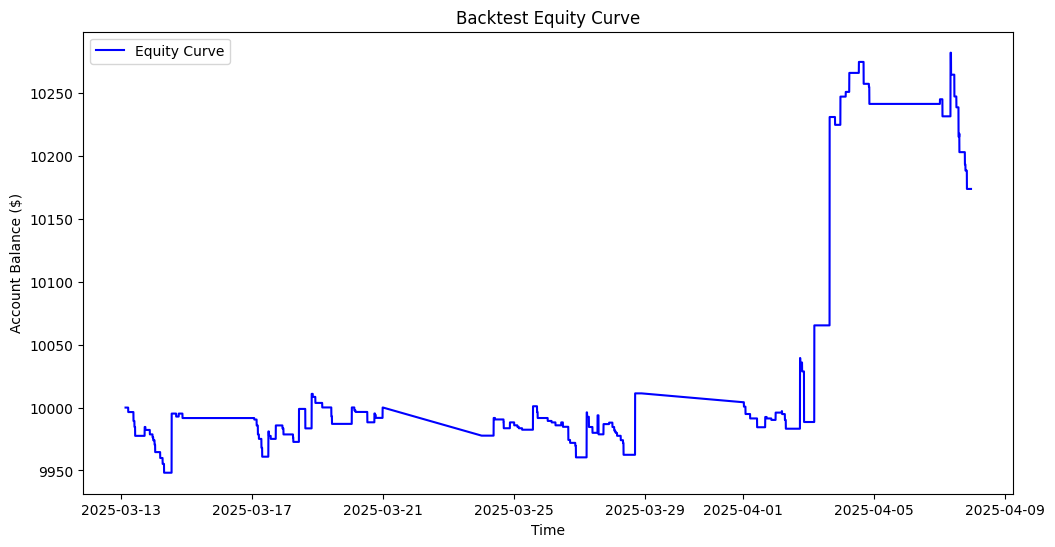

In [18]:
plot_equity_curve(trades_opt)

In [19]:
import mplfinance as mpf

def plot_chart():
    # Define the moving average plots
    ma_plots = [
        mpf.make_addplot(df['MA_short'], color='blue', width=0.5, label=f'{short_period_opt} MA'),
        mpf.make_addplot(df['MA_long'], color='red', width=0.5, label=f'{long_period_opt} MA')
    ]


    fig, ax = mpf.plot(df, type='candle', style='charles', volume=False, addplot=ma_plots, returnfig=True)

    # ✅ Set the figure DPI manually
    fig.set_dpi(300)

    plt.show()

d:\Programming\Machine Learning Works\tensorflow_env\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
d:\Programming\Machine Learning Works\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


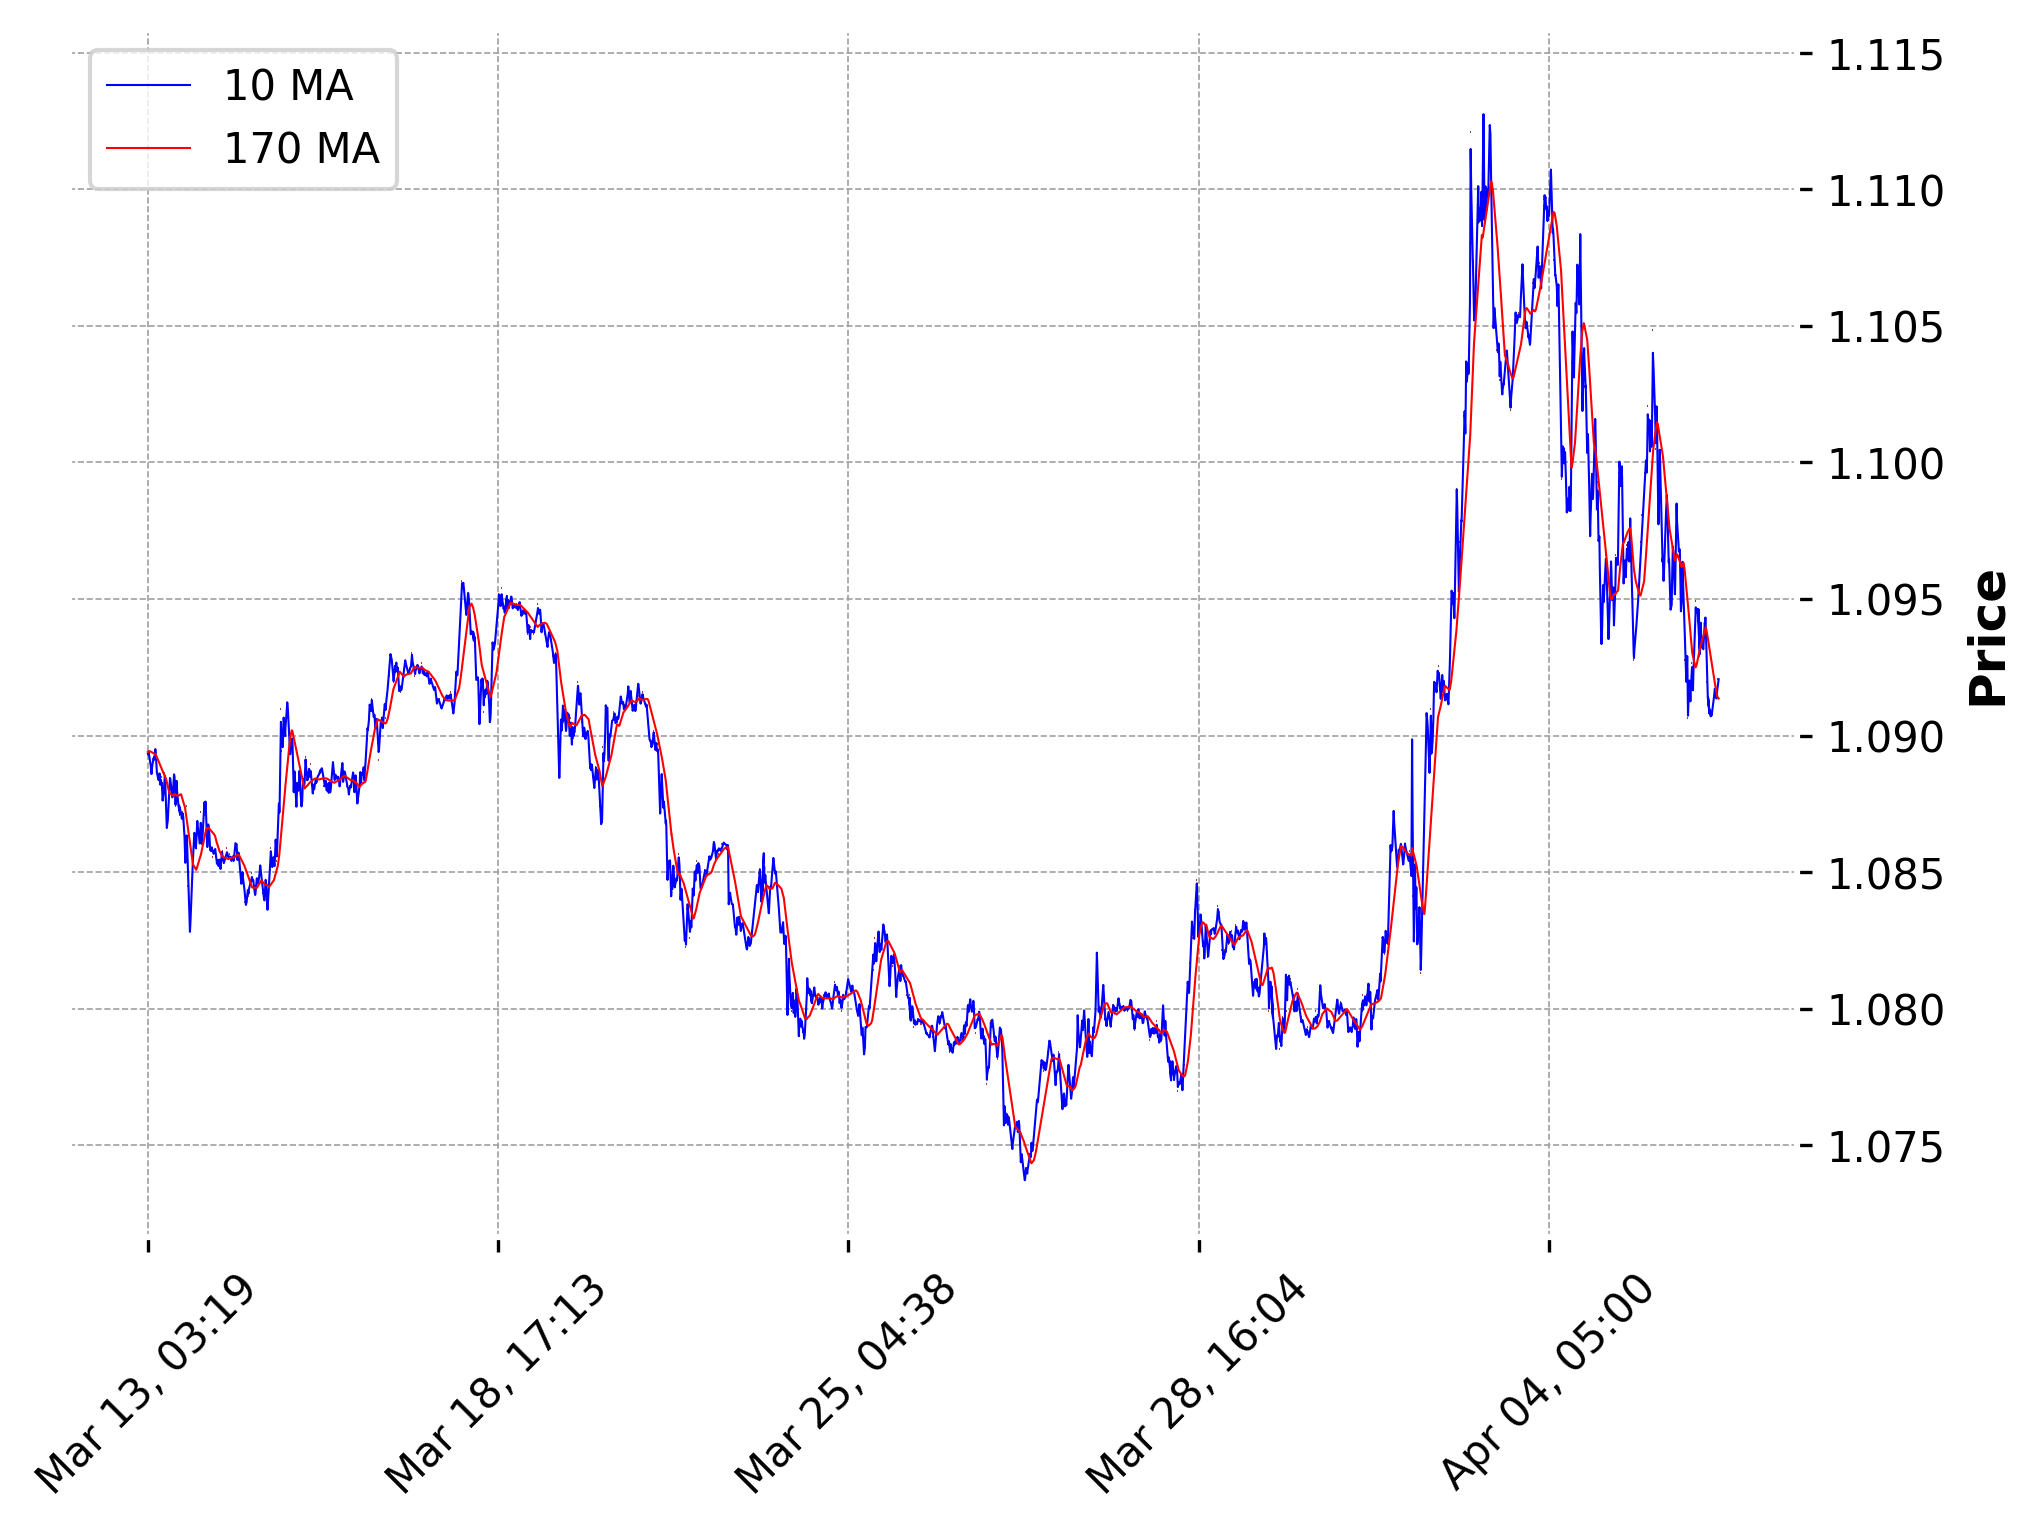

In [20]:
plot_chart()

In [21]:
data

,Time_Diff,Signal,Profit
Datetime,,,
2025-03-13 04:57:00+00:00,0 days 00:17:00,1.0,-3.559589
2025-03-13 08:29:00+00:00,0 days 00:36:00,1.0,-7.102345
2025-03-13 09:14:00+00:00,0 days 00:34:00,1.0,-4.727563
2025-03-13 10:01:00+00:00,0 days 00:17:00,1.0,-7.090369
2025-03-13 14:02:00+00:00,0 days 03:15:00,1.0,7.061545
...,...,...,...
2025-04-07 14:22:00+00:00,0 days 00:02:00,1.0,-14.734943
2025-04-07 17:00:00+00:00,0 days 01:27:00,1.0,-9.758450
2025-04-07 18:33:00+00:00,0 days 00:19:00,1.0,-4.877596


In [22]:
def processed_data(data):
    # Assuming data is your DataFrame
    # Convert Datetime
    data['Datetime'] = pd.to_datetime(data.index)
    data['Year'] = data['Datetime'].dt.year
    data['Month'] = data['Datetime'].dt.month
    data['Day'] = data['Datetime'].dt.day
    data['Hour'] = data['Datetime'].dt.hour
    data['Minute'] = data['Datetime'].dt.minute
    data['DayOfWeek'] = data['Datetime'].dt.dayofweek

    # Convert Time_Diff to hours
    data['Time_Diff_Hours'] = data['Time_Diff'].dt.total_seconds() / 3600

    data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
    data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
    data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

    data.index = range(0, len(data))
    data['Time_Diff_Hours'] = data['Time_Diff'].dt.total_seconds() / 3600

    # Map Signal to 0 and 1 for binary classification (if needed)
    data['Signal'] = data['Signal'].map({-1.0: 0, 1.0: 1})
    # Or one-hot encode for multi-class
    data = pd.get_dummies(data, columns=['Signal'], prefix='Signal')

    return data

In [23]:
data = processed_data(data)

In [26]:
# Features and target
features = ['Signal_1', 'Time_Diff_Hours',  'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']
target = 'Profit'

In [27]:
data[features]

,Signal_1,Time_Diff_Hours,Year,Month,Day,Hour,Minute,DayOfWeek,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,True,0.283333,2025,3,13,4,57,3,1.000000,6.123234e-17,0.433884,-0.900969
1,True,0.600000,2025,3,13,8,29,3,1.000000,6.123234e-17,0.433884,-0.900969
2,True,0.566667,2025,3,13,9,14,3,1.000000,6.123234e-17,0.433884,-0.900969
3,True,0.283333,2025,3,13,10,1,3,1.000000,6.123234e-17,0.433884,-0.900969
4,True,3.250000,2025,3,13,14,2,3,1.000000,6.123234e-17,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...
133,True,0.033333,2025,4,7,14,22,0,0.866025,-5.000000e-01,0.000000,1.000000
134,True,1.450000,2025,4,7,17,0,0,0.866025,-5.000000e-01,0.000000,1.000000
135,True,0.316667,2025,4,7,18,33,0,0.866025,-5.000000e-01,0.000000,1.000000
136,True,0.500000,2025,4,7,19,25,0,0.866025,-5.000000e-01,0.000000,1.000000


In [28]:
profit_unscaled = data['Profit']

In [31]:
from sklearn.preprocessing import MinMaxScaler

def scaled_data(data):
        
    # Features to scale
    features_to_scale = ['Time_Diff_Hours',  'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek']
    target = 'Profit'

    # Scale features
    feature_scaler = MinMaxScaler()
    data[features_to_scale] = feature_scaler.fit_transform(data[features_to_scale])

    # Scale target (Profit)
    target_scaler = MinMaxScaler()
    data[[target]] = target_scaler.fit_transform(data[[target]])

    return data

In [32]:
data = scaled_data(data)

In [33]:
data

,Time_Diff,Profit,Datetime,Year,Month,Day,Hour,Minute,DayOfWeek,Time_Diff_Hours,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,Signal_1
0,0 days 00:17:00,0.178071,2025-03-13 04:57:00+00:00,0.0,0.0,0.444444,0.173913,0.966102,0.75,0.003492,1.000000,6.123234e-17,0.433884,-0.900969,True
1,0 days 00:36:00,0.160868,2025-03-13 08:29:00+00:00,0.0,0.0,0.444444,0.347826,0.491525,0.75,0.007639,1.000000,6.123234e-17,0.433884,-0.900969,True
2,0 days 00:34:00,0.172399,2025-03-13 09:14:00+00:00,0.0,0.0,0.444444,0.391304,0.237288,0.75,0.007202,1.000000,6.123234e-17,0.433884,-0.900969,True
3,0 days 00:17:00,0.160927,2025-03-13 10:01:00+00:00,0.0,0.0,0.444444,0.434783,0.016949,0.75,0.003492,1.000000,6.123234e-17,0.433884,-0.900969,True
4,0 days 03:15:00,0.229643,2025-03-13 14:02:00+00:00,0.0,0.0,0.444444,0.608696,0.033898,0.75,0.042340,1.000000,6.123234e-17,0.433884,-0.900969,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0 days 00:02:00,0.123808,2025-04-07 14:22:00+00:00,0.0,1.0,0.222222,0.608696,0.372881,0.00,0.000218,0.866025,-5.000000e-01,0.000000,1.000000,True
134,0 days 01:27:00,0.147971,2025-04-07 17:00:00+00:00,0.0,1.0,0.222222,0.739130,0.000000,0.00,0.018769,0.866025,-5.000000e-01,0.000000,1.000000,True
135,0 days 00:19:00,0.171671,2025-04-07 18:33:00+00:00,0.0,1.0,0.222222,0.782609,0.559322,0.00,0.003928,0.866025,-5.000000e-01,0.000000,1.000000,True
136,0 days 00:30:00,0.124385,2025-04-07 19:25:00+00:00,0.0,1.0,0.222222,0.826087,0.423729,0.00,0.006329,0.866025,-5.000000e-01,0.000000,1.000000,True


In [34]:
data[['Profit']]

,Profit
0,0.178071
1,0.160868
2,0.172399
3,0.160927
4,0.229643
...,...
133,0.123808
134,0.147971
135,0.171671
136,0.124385


In [89]:
if data['Time_Diff'][-1:].values[0].astype != data['Time_Diff'][1:].values[0].astype:
    data = data[:-1]
elif data['Time_Diff'][0:1].values[0].astype != data['Time_Diff'][1:].values[0].astype:
    data = data[1:]

In [92]:
def create_sequences(data, seq_length, feature_cols, target_col):
    X, y = [], []
    for i in range(len(data)):
        X.append(data[feature_cols].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i])
        
    return np.array(X), np.array(y)

# Define features and target
feature_cols = ['Time_Diff_Hours',  'Year', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',  'Hour', 'Minute' ]
target_col = 'Profit'  # Or 'Signal' for classification
seq_length = 1  # Use past 5 time steps

X, y = create_sequences(data, seq_length, feature_cols, target_col)

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for regression (Profit)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


d:\Programming\Machine Learning Works\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0509 - val_loss: 0.0812
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0356 - val_loss: 0.0683
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0217 - val_loss: 0.0583
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0142 - val_loss: 0.0500
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0089 - val_loss: 0.0442
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0050 - val_loss: 0.0410
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0038 - val_loss: 0.0398
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035 - val_loss: 0.0393
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041 - val_loss: 0.0388
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0047 - val_loss: 0.0382
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0380
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031 - val_loss: 0.0383
Epoch 13/50


In [95]:
# Evaluate
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0385
Test Loss: 0.038537584245204926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [96]:
y_pred_actual = y_pred*( max(profit_unscaled) - min(profit_unscaled) ) + min(profit_unscaled)

In [97]:
y_pred_actual

array([[-0.6355133 ],
       [-1.3308678 ],
       [-0.82434464],
       [-0.03258133],
       [-0.02004623],
       [-0.00928879],
       [ 0.31040573],
       [-3.7758331 ],
       [-1.0899963 ],
       [-0.984684  ],
       [-0.10605621],
       [-0.5942154 ],
       [ 0.5167084 ],
       [ 1.673523  ],
       [ 2.1327171 ],
       [ 2.3476295 ],
       [-0.29971313],
       [-0.45066452],
       [-0.28842163],
       [ 0.6081734 ],
       [-0.03458023],
       [ 0.97752   ],
       [ 0.2119751 ],
       [ 0.5504608 ],
       [ 0.46561432],
       [ 1.2095222 ],
       [ 0.50800705],
       [ 0.5560417 ]], dtype=float32)

In [98]:
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2025-04-09', end='2025-04-11', interval='1m')

[*********************100%***********************]  1 of 1 completed


In [ ]:
def find_param_new(data, initial_balance=10000, risk_per_trade=0.01, short_period, long_period):
    # Rename columns
    data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    
    # Define parameter ranges
    short_periods = short_period_opt
    long_periods = long_period_opt
    
    # Precompute all moving averages
    ma_data = {}
    for period in set(short_periods) | set(long_periods):
        ma_data[period] = data['Close'].rolling(window=period).mean()
    
    # Create a DataFrame to store all moving averages
    ma_df = pd.DataFrame(ma_data, index=data.index)
    ma_df = ma_df.join(data[['Close', 'High', 'Low', 'Open']])
    
    # Drop rows with any NaN values (due to rolling windows)
    ma_df = ma_df.dropna()
    
    # Initialize variables for tracking optimal results
    max_profit = -np.inf
    short_period_opt = 0
    long_period_opt = 0
    trades_opt = 0
    best_df = None
    
    # Iterate over valid period combinations
    for short_period, long_period in product(short_periods, long_periods):
        if long_period <= short_period:
            continue  # Skip invalid combinations
        
        # Extract relevant moving averages
        df = ma_df[['Close', 'High', 'Low', 'Open']].copy()
        df['MA_short'] = ma_df[short_period]
        df['MA_long'] = ma_df[long_period]
        
        # Generate signals
        df['Signal'] = np.where(df['MA_short'] > df['MA_long'], 1, 0)
        df['Signal'] = df['Signal'].diff()
        
        # Assign buy/sell signals
        df['Buy_Signal'] = np.where(df['Signal'] == 1, df['Close'], np.nan)
        df['Sell_Signal'] = np.where(df['Signal'] == -1, df['Close'], np.nan)
        
        # Compute profit and trades
        profit, trades = analyze_results(df, initial_balance, risk_per_trade)
        
        # Update optimal parameters if profit is higher
        if profit > max_profit:
            max_profit = profit
            short_period_opt = short_period
            long_period_opt = long_period
            trades_opt = trades
            best_df = df.copy()  # Store only the optimal DataFrame
    
    return max_profit, trades_opt, best_df

In [103]:
short_period_opt, long_period_opt

(10, 170)

In [104]:
max_profit, trades_opt, df_opt = find_param_new(data, short_period_opt, long_period_opt)

UnboundLocalError: local variable 'short_period_opt' referenced before assignment

In [ ]:
df = df_opt

In [ ]:
df, data = cleaned_data(data)

In [ ]:
df

,Close,High,Low,Open,MA_short,MA_long,Signal,Buy_Signal,Sell_Signal,Balance
Datetime,,,,,,,,,,
2025-04-09 02:19:00+00:00,1.102293,1.102293,1.102293,1.102293,1.102774,1.100339,NaN,NaN,NaN,10000.000000
2025-04-09 02:20:00+00:00,1.102293,1.102293,1.102293,1.102293,1.102743,1.100365,0.0,NaN,NaN,10000.000000
2025-04-09 02:21:00+00:00,1.102050,1.102050,1.102050,1.102050,1.102723,1.100389,0.0,NaN,NaN,10000.000000
2025-04-09 02:22:00+00:00,1.102293,1.102293,1.102293,1.102293,1.102709,1.100414,0.0,NaN,NaN,10000.000000
2025-04-09 02:23:00+00:00,1.102536,1.102536,1.102536,1.102536,1.102701,1.100439,0.0,NaN,NaN,10000.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-10 22:54:00+00:00,1.123722,1.123722,1.123722,1.123722,1.121917,1.120157,0.0,NaN,NaN,9923.735781
2025-04-10 22:55:00+00:00,1.122838,1.122838,1.122838,1.122838,1.121952,1.120186,0.0,NaN,NaN,9923.735781
2025-04-10 22:56:00+00:00,1.122712,1.122712,1.122712,1.122712,1.121992,1.120214,0.0,NaN,NaN,9923.735781


d:\Programming\Machine Learning Works\tensorflow_env\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


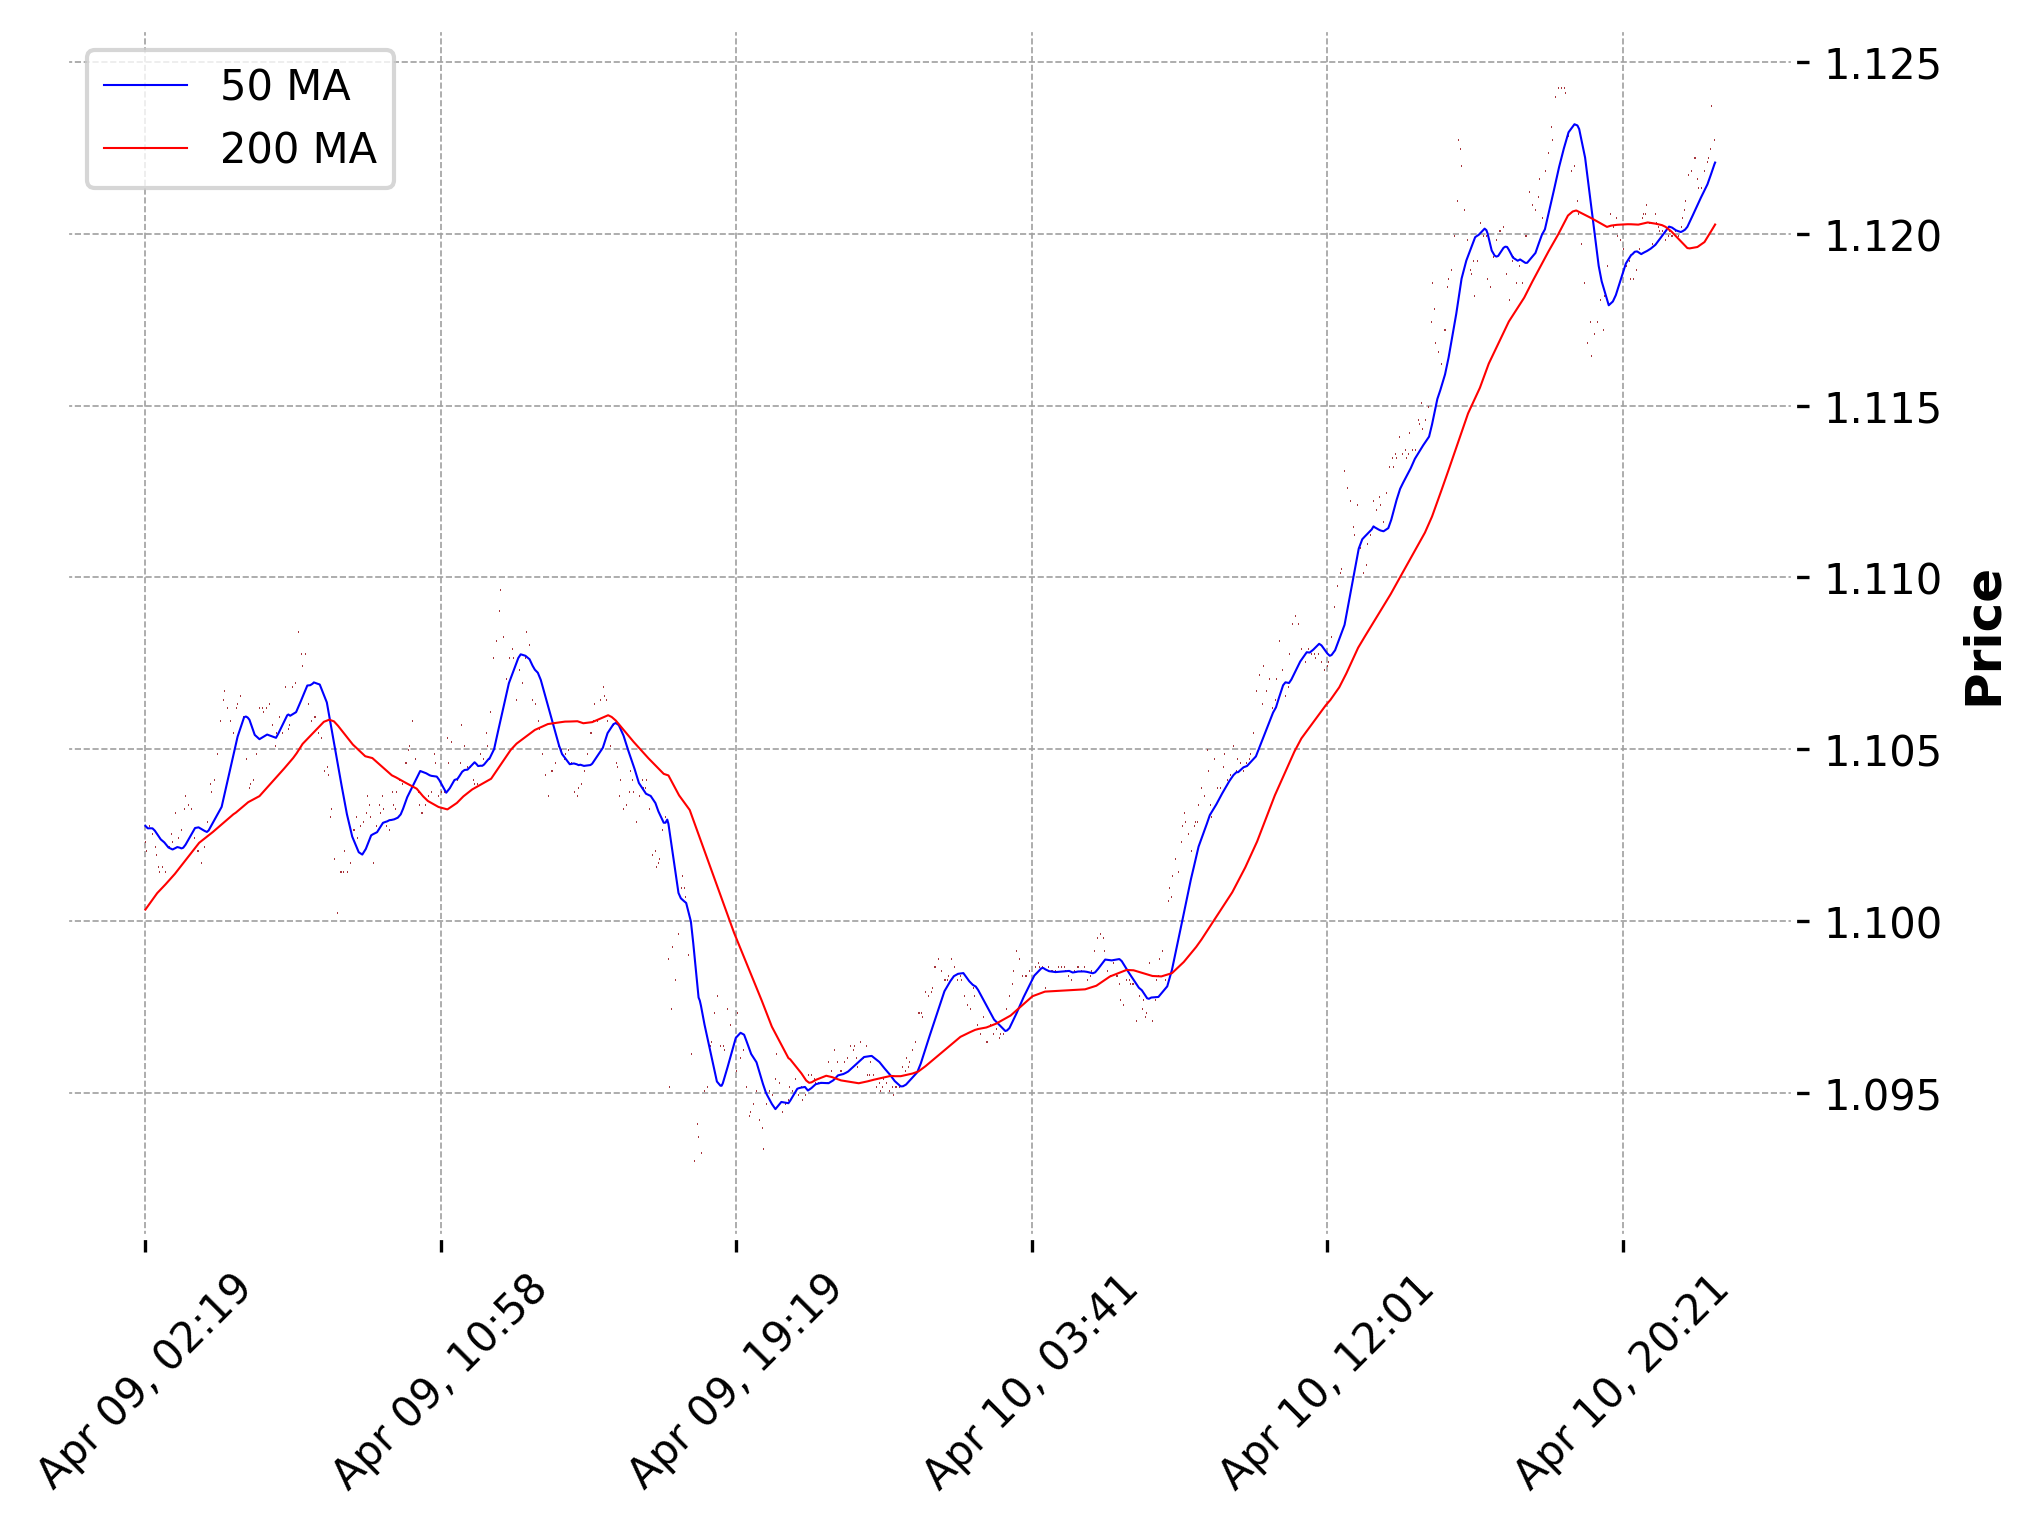

In [ ]:
plot_chart()

Total Profit: $-76.26
Total Trades: 6


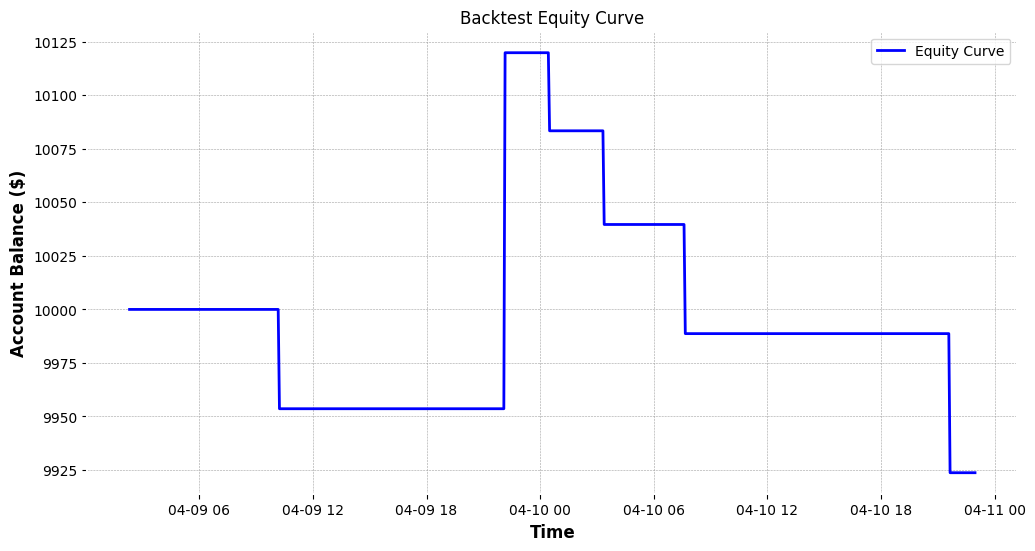

In [ ]:
plot_equity_curve(trades_opt)

In [ ]:
profit_unscaled_new = data['Profit']

In [ ]:
df[df['Signal'] == 1]

,Close,High,Low,Open,MA_short,MA_long,Signal,Buy_Signal,Sell_Signal,Balance
Datetime,,,,,,,,,,
2025-04-09 10:11:00+00:00,1.105950,1.105950,1.105950,1.105950,1.103992,1.103954,1.0,1.105950,NaN,9953.620434
2025-04-09 22:06:00+00:00,1.096011,1.096011,1.096011,1.096011,1.095442,1.095416,1.0,1.096011,NaN,10119.879411
2025-04-10 00:27:00+00:00,1.096852,1.096852,1.096852,1.096852,1.095639,1.095619,1.0,1.096852,NaN,10083.412847
2025-04-10 03:20:00+00:00,1.098901,1.098901,1.098901,1.098901,1.097534,1.097528,1.0,1.098901,NaN,10039.663527
2025-04-10 07:37:00+00:00,1.100715,1.100715,1.100715,1.100715,1.098521,1.098476,1.0,1.100715,NaN,9988.695701
2025-04-10 21:36:00+00:00,1.119946,1.119946,1.119946,1.119946,1.120175,1.120168,1.0,1.119946,NaN,9923.735781


In [ ]:
data

,Time_Diff,Signal,Profit
Datetime,,,
2025-04-09 07:52:00+00:00,0 days 02:19:00,-1.0,-46.379566
2025-04-09 14:10:00+00:00,0 days 07:56:00,-1.0,166.258977
2025-04-09 23:42:00+00:00,0 days 00:45:00,-1.0,-36.466565
2025-04-10 02:44:00+00:00,0 days 00:36:00,-1.0,-43.749320
2025-04-10 06:23:00+00:00,0 days 01:14:00,-1.0,-50.967826
2025-04-10 19:30:00+00:00,0 days 02:06:00,-1.0,-64.959920


In [ ]:
profit_unscaled_new

Datetime
2025-04-09 07:52:00+00:00    -46.379566
2025-04-09 14:10:00+00:00    166.258977
2025-04-09 23:42:00+00:00    -36.466565
2025-04-10 02:44:00+00:00    -43.749320
2025-04-10 06:23:00+00:00    -50.967826
2025-04-10 19:30:00+00:00    -64.959920
Name: Profit, dtype: float64

In [ ]:
data = processed_data(data)

In [ ]:
data = scaled_data(data)

In [ ]:
# Define features and target
feature_cols = ['Time_Diff_Hours', 'Year', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',  'Hour', 'Minute' ]
target_col = 'Profit'  # Or 'Signal' for classification
seq_length = 1# Use past 5 time steps

X, y = create_sequences(data, seq_length, feature_cols, target_col)

In [ ]:
X

array([[[ 0.23409091,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.23809524,  1.        ]],

       [[ 1.        ,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.57142857,  0.        ]],

       [[ 0.02045455,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  1.        ,  0.76190476]],

       [[ 0.        ,  0.        ,  0.8660254 , -0.5       ,
          0.43388374, -0.90096887,  0.        ,  0.80952381]],

       [[ 0.08636364,  0.        ,  0.8660254 , -0.5       ,
          0.43388374, -0.90096887,  0.19047619,  0.30952381]],

       [[ 0.20454545,  0.        ,  0.8660254 , -0.5       ,
          0.43388374, -0.90096887,  0.80952381,  0.47619048]]])

In [ ]:
# Evaluate
loss = model.evaluate(X, y)
print(f"Test Loss: {loss}")

# Predict
y_pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1289
Test Loss: 0.12888485193252563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [ ]:
y_pred_actual = y_pred*( max(profit_unscaled) - min(profit_unscaled) ) + min(profit_unscaled)

In [ ]:
y_pred_actual

array([[10.338821  ],
       [26.281174  ],
       [ 2.5711212 ],
       [ 3.8129883 ],
       [ 3.05159   ],
       [-0.20827484]], dtype=float32)

In [ ]:
y_actual = y*( max(profit_unscaled_new) - min(profit_unscaled_new) ) + min(profit_unscaled_new)

In [ ]:
y_actual

array([-46.37956619, 166.25897741, -36.46656452, -43.74931979,
       -50.96782577, -64.95992008])

In [ ]:
data

,Time_Diff,Profit,Datetime,Year,Month,Day,Hour,Minute,DayOfWeek,Time_Diff_Hours,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,Signal_0
0,0 days 02:19:00,0.080358,2025-04-09 07:52:00+00:00,0.0,0.0,0.0,0.238095,1.000000,0.0,0.234091,0.866025,-0.5,0.974928,-0.222521,True
1,0 days 07:56:00,1.000000,2025-04-09 14:10:00+00:00,0.0,0.0,0.0,0.571429,0.000000,0.0,1.000000,0.866025,-0.5,0.974928,-0.222521,True
2,0 days 00:45:00,0.123231,2025-04-09 23:42:00+00:00,0.0,0.0,0.0,1.000000,0.761905,0.0,0.020455,0.866025,-0.5,0.974928,-0.222521,True
3,0 days 00:36:00,0.091734,2025-04-10 02:44:00+00:00,0.0,0.0,1.0,0.000000,0.809524,1.0,0.000000,0.866025,-0.5,0.433884,-0.900969,True
4,0 days 01:14:00,0.060514,2025-04-10 06:23:00+00:00,0.0,0.0,1.0,0.190476,0.309524,1.0,0.086364,0.866025,-0.5,0.433884,-0.900969,True
5,0 days 02:06:00,0.000000,2025-04-10 19:30:00+00:00,0.0,0.0,1.0,0.809524,0.476190,1.0,0.204545,0.866025,-0.5,0.433884,-0.900969,True
